In [54]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
from functools import partial
from IPython.display import clear_output
import time
import optax
from tqdm import tqdm



num_particles = 2
hbar = 1
m = 1
omegas = jnp.array([1, 1])

In [55]:
## define the neural network class

class Network:
    #[1, 5, 10, 10, 10, 10, 5, 1]
    def __init__(self, node_counts=[num_particles, 50, 1]):
        # defining the structure of the neural network
        self.num_layers = len(node_counts)
        # the number of nodes for each layer
        self.node_counts = node_counts
        # the total number of weights
        self.params_length = 0
        for i in range(self.num_layers - 1):
            self.params_length += node_counts[i] * node_counts[i + 1]
            i+=1
        # the list that stores the weight matrices (index 0 is the connections from the input to the first hidden layer)
        self.weights = []
        # storage for all the biases
        self.biases = []
        
        # generate weight matrices with the correct sizes, and random elements
        for i in range(self.num_layers - 1):
            self.weights.append(np.random.randn(node_counts[i + 1], node_counts[i]) * np.sqrt(1. / (node_counts[i + 1])))
        self.weights = np.array(self.weights, dtype=object)
        
        # generate the bias arrays
        for i in range(self.num_layers - 1):
            temp = np.random.randn(node_counts[i + 1]) * np.sqrt(1. / node_counts[i + 1])
            self.biases.append(temp[:, None])
        self.biases = np.array(self.biases, dtype=object)
        # get the shape for reshaping a 1d array to this later
        self.dimensions = []
        for m in self.weights:
            self.dimensions.append(m.shape)

    # define the activation function that we use for the layers
    @partial(jit, static_argnums=[0])
    def l_act(self, x):
        return celu(x)
        #return 1.0 / (1.0 + jnp.exp(-x))    
    # define the activation function for the output
    @partial(jit, static_argnums=[0])
    def o_act(self, x):
        return celu(x)
        #return x
        #return 1.0 / (1.0 + jnp.exp(-x))
    
    @partial(jit, static_argnums=(0,))
    def conv1d(self):
        flattened = []
        # loop through each matrix
        for m in range(self.num_layers - 1):
            mat = self.weights[m]
            for i in range(mat.shape[0]):
                for j in range(mat.shape[1]):
                    flattened.append(mat[i][j])
        for m in range(self.num_layers - 1):
            # add the biases onto the end
            bias = self.biases[m]
            for element in bias:
                flattened.append(element)
        return jnp.array(flattened)
        
    @partial(jit, static_argnums=(0,))
    def convnd(self, params):
        ret = []
        ret_bias = []
        # the last index of the matrix
        max_ind = 0
        prev_ind = 0
        for dim in self.dimensions:
            max_ind += dim[0]*dim[1]
            temp = params[prev_ind : max_ind]
            prev_ind = max_ind
            ret.append(jnp.array(temp).reshape(dim))
        biases_flattened = params[max_ind :]
        # now reconstruct the bias matrices
        # print(biases_flattened)
        ind = 0
        for i in range(self.num_layers - 1):
            ret_bias.append((biases_flattened[ind: ind + self.node_counts[i + 1]])[:, None])
            ind += self.node_counts[i + 1]
        return ret, ret_bias


    # passing inputs into the neural network and getting an output
    @partial(jit, static_argnums=[0])
    def output(self, coords, params):
        # format the parameters as weights
        c = self.convnd(params)
        self.weights = c[0]
        self.biases = c[1]
        # compute the output of the neural network
        for i in range(self.num_layers - 1):
            w = jnp.array(self.weights[i])
            b = jnp.array(self.biases[i])
            # print(w)
            # print(b)
            # if its the first layer, dot it against the input and use the activation function
            if i == 0:
                temp = self.l_act(jnp.dot(w, coords))
            elif (i < self.num_layers):
                
                temp = self.l_act(jnp.dot(w, temp) + b)
            else:
                # on the output layer we use the output activation function
                temp = self.o_act(jnp.dot(w, temp) + b)
        # print("output:" + str(time.time() -  start))
        return temp[0]

In [56]:
# create the network object
nn = Network()

@jit
def psi(coords, params):
    return jnp.exp(-nn.output(coords, params)[0]) * np.prod(jnp.exp(-coords**2))

@jit
def sample_body(coords_t, params, key):    
    gen_rand = jax.random.uniform(key, minval=-5, maxval=5, shape=(num_particles,))
    new_key, subkey = jax.random.split(key)
    del key
    
    coords_prime = coords_t + gen_rand
    temp_rand = jax.random.uniform(subkey, minval=0, maxval=1)
    return (jax.lax.cond(temp_rand < psi(coords_prime, params)**2/psi(coords_t, params)**2, lambda x, y: x, lambda x, y : y, coords_prime, coords_t), new_key)

def sample(params, num_samples=10**3, thermalization_steps=200, skip_count=10, key=jax.random.PRNGKey(np.random.randint(0,100))):
    outputs = []
    # e_plots = []
    coords_t = np.random.uniform(-5, 5, num_particles)
    for step in range(num_samples*skip_count + thermalization_steps + 1):
        coords_t, key = sample_body(coords_t, params, key)
        if ((step > thermalization_steps) & (step % skip_count == 0)):
            outputs.append(coords_t)
    return jnp.array(outputs)

h = hessian(psi)

@jit
def ddpsi(coords, params):
    return jnp.diagonal(h(coords, params))


#TODO: implement particle-particle interaction
@jit
def Hpsi(coords, params):
    return  jnp.sum(m*.5*jnp.multiply(omegas**2,coords**2)) - hbar**2 / (2*m) * jnp.sum(ddpsi(coords, params)) * 1/psi(coords, params)

venergy = vmap(Hpsi, in_axes=(0, None), out_axes=0)

@jit
def logpsi(coords, params):
    return jnp.log(psi(coords, params))

# define the derivative with respect to every parameter of the log of psi:
dlogpsi_dtheta_stored = jit(grad(logpsi, 1))

vlog_term = jit(vmap(dlogpsi_dtheta_stored, in_axes=(0, None), out_axes=0))

vboth = vmap(jnp.multiply, in_axes=(0, 0), out_axes=0)

def gradient(params, num_samples=10**3, verbose=True):
    # get the samples
    samples = sample(params, num_samples)
    psiHpsi = venergy(samples, params)
    logs = vlog_term(samples, params)

    energy = 1/num_samples * jnp.sum(psiHpsi)
    if verbose:
        print(energy)
    log_term = 1/num_samples * jnp.sum(logs,0)

    both = 1/num_samples * jnp.sum(vboth(psiHpsi, logs),0)

    gradient_calc = (2 * both - 2*energy * log_term)
    return gradient_calc, energy

def avg_energy(params, num_samples = 10**3):
    samples = sample(params, num_samples)
    psiHpsi = venergy(samples, params)
    return 1/num_samples * jnp.sum(psiHpsi)


weight1 = []
last_bias = []
energies = []
def vgrad_opt(start_params, num_samples=10**3, learning_rate=.1, max_iterations=5000, tolerance=.000001, verbose=False):
    params = start_params
    hist = [start_params]
    start = time.time()
    for it in range(max_iterations):
        clear_output(wait=True)
        if verbose:
            print("iteration " + str(it))
        gr = gradient(params, num_samples, verbose=verbose)
        energies.append(gr[1])
        diff = jnp.asarray((learning_rate * gr[0]))
        #print(diff)
        # make a step in the direction opposite the gradient
        params = params - diff
        #weight1.append(params[0])
        #last_bias.append(params[-1])
        
        # print(params)
        hist.append(params)
    elapsed = time.time() - start
    if verbose:
        print("Iterations per second: " + str(elapsed/max_iterations))
    return hist

# adam optimizer seems to be solidly faster than my own one.
def adam_opt(params, optimizer, num_samples=10**3, learning_rate=.1, max_iterations=2000, tolerance=.00001, verbose=False):
    hist = []
    opt_state = optimizer.init(params)
    start = time.time()
    def step(params, opt_state):
        if verbose:
            clear_output(wait=True)
        gr = gradient(params, num_samples, verbose=verbose)
        hist.append(gr[1])
        updates, opt_state = optimizer.update(gr[0], opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, gr[1]
    pbar = tqdm(range(max_iterations),desc="", leave=True)
    for _ in pbar:
        params, opt_state, energy = step(params, opt_state)
        if np.isnan(energy):
            break
        pbar.set_description("energy = " + str(energy), refresh=True)
    
    elapsed = time.time() - start
    if verbose:
        print("Iterations per second: " + str(elapsed/max_iterations))
    return hist


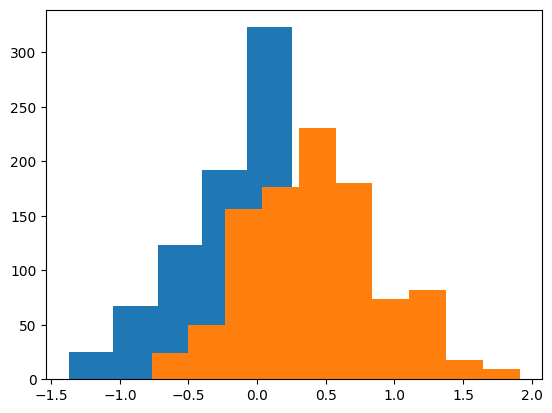

In [57]:
samples = sample(nn.conv1d())
sx = [s[0] for s in samples]
sy = [s[1] for s in samples]
plt.hist(sx)
plt.hist(sy)
plt.show()


In [58]:
# use the homemade gradient descent
# optd = vgrad_opt(nn.conv1d(), verbose=True)


In [59]:
a_optd = adam_opt(nn.conv1d(), optax.adam(learning_rate=.1), verbose=False)

energy: 1.0197775:  60%|██████    | 1207/2000 [02:12<01:27,  9.04it/s] 

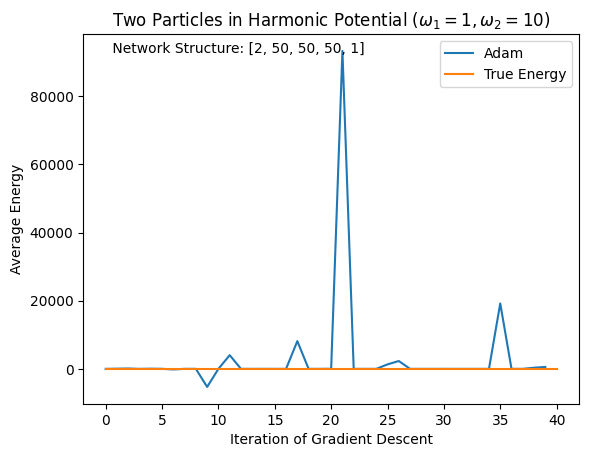

In [ ]:
plt.title(r"Two Particles in Harmonic Potential ($\omega_1 = 1, \omega_2 = 10$)")
plt.xlabel("Iteration of Gradient Descent")
plt.ylabel("Average Energy")
# plt.plot(np.arange(0,len(optd[1:])), energies, label="Naive Gradient Descent")

# get the network structure
structure = nn.node_counts
plt.annotate(" Network Structure: " + str(structure), xy=(0.05, 0.95), xycoords='axes fraction')



# now plot the adam optimizer run
plt.plot(np.arange(0, len(a_optd)), a_optd, label="Adam")
# plot the line for the true ground state energy
true_energy = np.sum(hbar/2 * omegas)
plt.plot(np.arange(0, len(a_optd)), [true_energy for x in np.arange(0, len(a_optd))], label=r"True Energy")
plt.legend()
plt.show()